# Training file for RDN

## Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import src.nntools as nt
from src.CarlaDataset import CarlaDataset, CarlaDatasetPatch
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS
import cv2

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()


if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

from src.rdn import RDN

print(device)

cuda


# Utility function

In [2]:
class SuperResolutionStatsManager(nt.StatsManager):
    def __init__(self):
        super(SuperResolutionStatsManager, self).__init__()

    def init(self):
        super(SuperResolutionStatsManager, self).init()
        # Initializing `self.running_psnr`
        self.running_psnr = 0
        self.running_ssim = 0

    def accumulate(self, loss, x, y, d):
        super(SuperResolutionStatsManager, self).accumulate(loss, x, y, d)
        # Updating `self.running_psnr`
        d_numpy = d.detach().to('cpu').numpy()
        y_numpy = y.detach().to('cpu').numpy()

        self.running_psnr += metrics.peak_signal_noise_ratio(d_numpy, y_numpy)

        current_ssim = 0

        for i in range(d_numpy.shape[0]):
            d_numpy_temp = np.moveaxis(d_numpy[i], [0, 1, 2], [2, 0, 1])
            y_numpy_temp = np.moveaxis(y_numpy[i], [0, 1, 2], [2, 0, 1])

            value_range = max(d_numpy_temp.max(), y_numpy_temp.max()) - min(d_numpy_temp.min(), y_numpy_temp.min())
            
            current_ssim += metrics.structural_similarity(d_numpy_temp, y_numpy_temp, win_size=7, data_range=value_range, multichannel=True, channel_axis=2)
        
        self.running_ssim += current_ssim / d_numpy.shape[0]

    def summarize(self):
        loss = super(SuperResolutionStatsManager, self).summarize()
        psnr = self.running_psnr / (self.number_update+1e-9 )
        ssim = self.running_ssim / (self.number_update+1e-9 )
        return {'loss': loss, 'psnr': psnr, "ssim": ssim}

def criterion(y, d):
    return F.mse_loss(y, d)

#show image
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    # ax.axis('off')
    return h

In [3]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy().transpose(1, 2, 0)

def tensor_to_image(tensor):
    return cv2.cvtColor(tensor_to_numpy(tensor), cv2.COLOR_BGR2RGB)

def numpy_to_tensor(numpy):
    return torch.from_numpy(numpy.astype(np.float32).transpose(2, 0, 1))

## Data loader

In [4]:
new_img_size = 256
common_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    common_transform,
    #transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(size=(new_img_size, new_img_size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
])

valid_transform = transforms.Compose([
    common_transform,
    #transforms.CenterCrop((new_img_size, new_img_size)),
])

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import your datasetclass

PATCH_SIZE = 32

full_train_dataset = CarlaDatasetPatch("1920x1080", "960x540", "train", transforms=train_transform, download=True, patch_size=PATCH_SIZE)
full_test_dataset = CarlaDatasetPatch("1920x1080", "960x540", "test", transforms=train_transform, download=True, patch_size=PATCH_SIZE)

train_dataset_patched = CarlaDatasetPatch("1920x1080", "960x540", "train", transforms=train_transform, download=True, patch_size=PATCH_SIZE)
test_dataset_patched = CarlaDatasetPatch("1920x1080", "960x540", "test", transforms=train_transform, download=True, patch_size=PATCH_SIZE)

SUBSET_SIZE = 4000
if len(train_dataset_patched) > SUBSET_SIZE:
    train_dataset_patched.limit_dataset(SUBSET_SIZE)

if len(test_dataset_patched) > SUBSET_SIZE * 0.2:
    test_dataset_patched.limit_dataset(int(SUBSET_SIZE * 0.2))

SUPER_RES_FACTOR = 2

print("Size of sub train dataset", len(train_dataset_patched))
print("Size of sub test dataset", len(test_dataset_patched))

Dataset already present
Dataset already present
Dataset already present
Dataset already present
Size of sub train dataset 4000
Size of sub test dataset 800


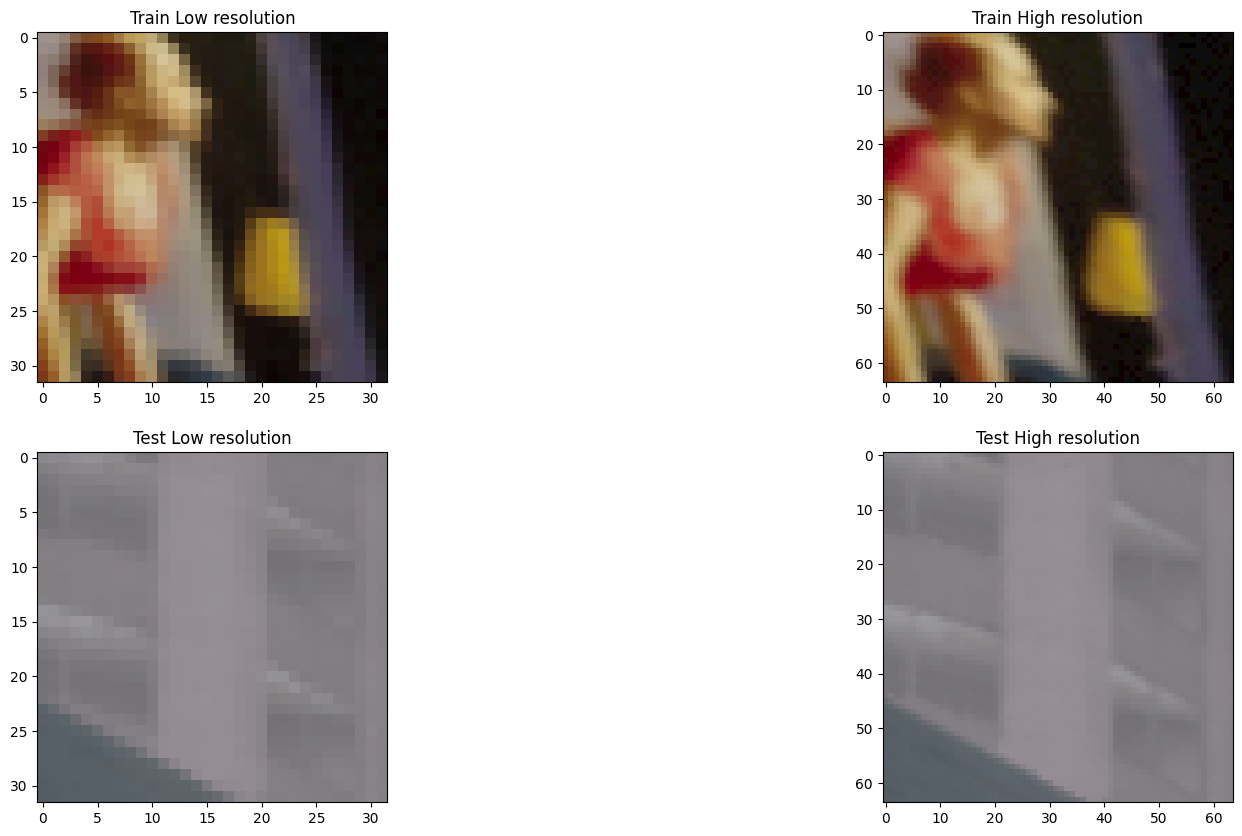

In [6]:
# Show one full image for both train and test
example1_low, example1_high = full_train_dataset[0]
example2_low, example2_high = full_test_dataset[0]

example1_low_image = tensor_to_image(example1_low)
example1_high_image = tensor_to_image(example1_high)

example2_low_image = tensor_to_image(example2_low)
example2_high_image = tensor_to_image(example2_high)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].imshow(example1_low_image)
ax[0, 0].set_title("Train Low resolution")
ax[0, 1].imshow(example1_high_image)
ax[0, 1].set_title("Train High resolution")
ax[1, 0].imshow(example2_low_image)
ax[1, 0].set_title("Test Low resolution")
ax[1, 1].imshow(example2_high_image)
ax[1, 1].set_title("Test High resolution")

plt.show()

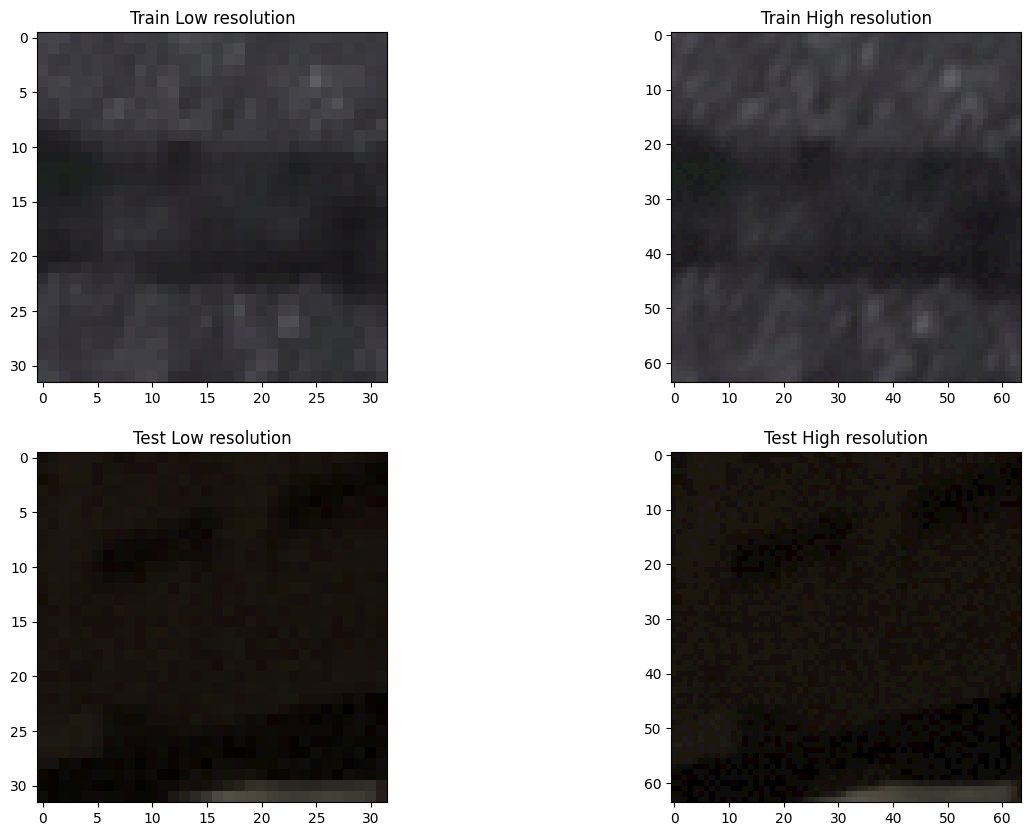

In [7]:
# Do the same for the patched dataset
example1_low, example1_high = train_dataset_patched[0]
example2_low, example2_high = test_dataset_patched[0]

example1_low_image = tensor_to_image(example1_low)
example1_high_image = tensor_to_image(example1_high)

example2_low_image = tensor_to_image(example2_low)
example2_high_image = tensor_to_image(example2_high)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].imshow(example1_low_image)
ax[0, 0].set_title("Train Low resolution")
ax[0, 1].imshow(example1_high_image)
ax[0, 1].set_title("Train High resolution")
ax[1, 0].imshow(example2_low_image)
ax[1, 0].set_title("Test Low resolution")
ax[1, 1].imshow(example2_high_image)
ax[1, 1].set_title("Test High resolution")

plt.show()

In [8]:
# Plot for the the predicted image, low resolution image and high resolution image in first row
# plot Plot the loss, psnr and ssim curves in the second row
def plot_images_and_metrics(exp, fig, axes, dataset, index): ##Only to use when perform_validation_during_training == True
    low_res, high_res = dataset[index]

    with torch.no_grad():
        predicted_res = exp.net(low_res.to(device))[0]

    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    axes[1][2].clear()

    low_res_image = tensor_to_image(low_res)
    high_res_image = tensor_to_image(high_res)
    predicted_res_image = tensor_to_image(predicted_res)

    axes[0][0].set_title(f'Low res: {low_res_image.shape}')
    axes[0][1].set_title(f'High res: {high_res_image.shape}')
    axes[0][2].set_title(f'Predicted res: {predicted_res_image.shape}')


    axes[0][0].imshow(low_res_image)
    axes[0][1].imshow(high_res_image)
    axes[0][2].imshow(predicted_res_image)

    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="Train loss")
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="Train psnr")
    axes[1][2].plot([exp.history[k][0]['ssim'] for k in range(exp.epoch)], label="Train ssim")

    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="Eval loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], label="Eval psnr")
    axes[1][2].plot([exp.history[k][1]['ssim'] for k in range(exp.epoch)], label="Eval ssim")

    axes[1][0].legend()
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")        
    axes[1][1].legend()
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR") 
    axes[1][2].legend()
    axes[1][2].set_xlabel("Epoch")
    axes[1][2].set_ylabel("SSIM")

## Training a model on a small dataset 

In [9]:
small_dataset_size = 10
small_dataset = [train_dataset_patched[np.random.randint(len(train_dataset_patched))] for _ in range(small_dataset_size)]

small_train_size = int(0.8 * len(small_dataset))
small_valid_size = len(small_dataset) - small_train_size
small_train_dataset, small_valid_dataset = torch.utils.data.random_split(small_dataset, [small_train_size, small_valid_size])

print("Size of small_train_dataset:", len(small_train_dataset))

Size of small_train_dataset: 8


In [10]:
lr = 1e-3
r = RDN(C=6 , D=20, G=64, G0=64, scaling_factor=2, kernel_size=3, c_dims=train_dataset_patched[0][0].shape[0], upscaling='shuffle', weights=None)
torch.cuda.empty_cache()
r = r.to(device)
# In mega bytes
print("Size of model mb", sum(p.numel() for p in r.parameters() if p.requires_grad) / (1024 * 1024))
# Size of batch in mega bytes
print("Size of batch mb", small_dataset[0][0].shape[0] * small_dataset[0][0].shape[1] * small_dataset[0][0].shape[2] * 4 / (1024 * 1024))

adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
path = "results/smallbatchexperiment-rnn"
exp = nt.Experiment(r, small_dataset, small_valid_dataset, adam, stats_manager, device, criterion, batch_size=1,
                     output_dir=path, perform_validation_during_training=True)

Size of model mb 15.593994140625
Size of batch mb 0.01171875


Start/Continue training from epoch 300
Finish training for 300 epochs


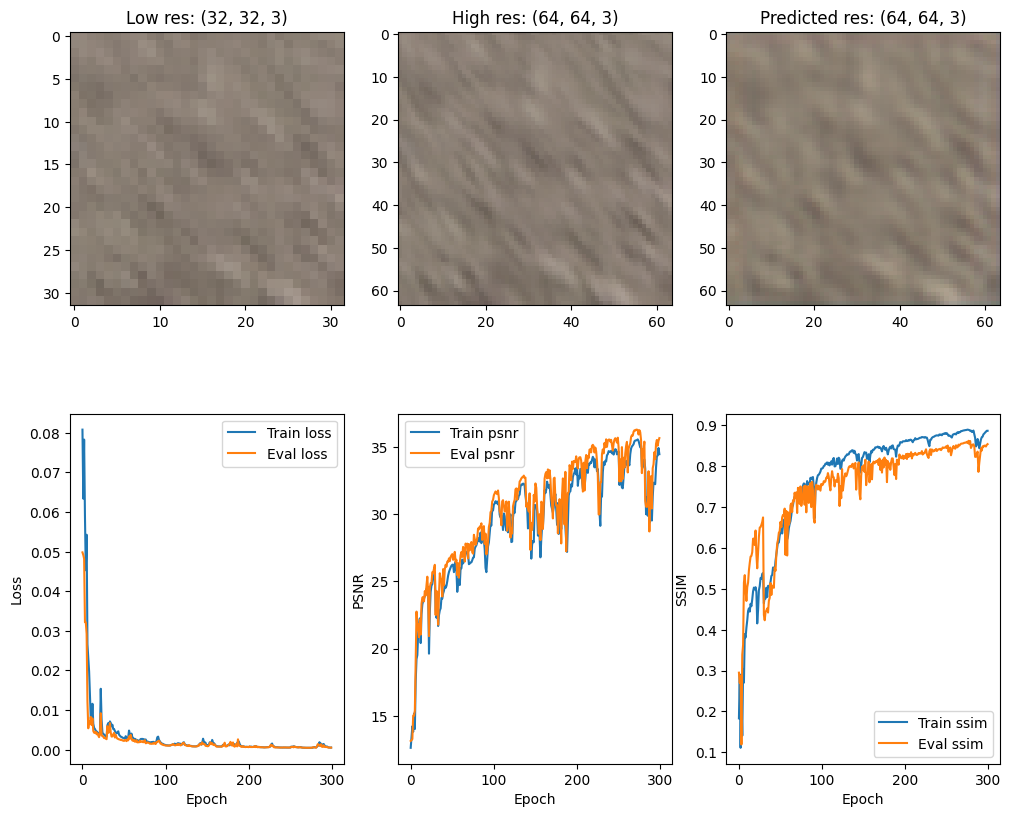

In [11]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 10))
exp.run(num_epochs=300, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, small_valid_dataset, np.random.randint(len(small_valid_dataset))))

In [12]:
# Show three images for a set and predict it
def plot_images_from_model(model, dataset, num_images=1, indices=None):
    images = []

    num_images = max(num_images, len(indices) if indices else 0)

    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    print(num_images)

    for i in range(num_images):
        if indices:
            low_res, high_res = dataset[indices[i]]
            print("Chosen index", indices[i])
        else:
            index = np.random.randint(len(dataset))
            low_res, high_res = dataset[index]
            print("Chosen index", index)

        images.append(low_res)
        images.append(high_res)

        with torch.no_grad():
            predicted_res = model.net(low_res.to(device))[0]

        images.append(predicted_res)

        low_res_image = tensor_to_image(low_res)
        high_res_image = tensor_to_image(high_res)
        predicted_res_image = tensor_to_image(predicted_res)

        axes[i, 0].set_title(f'Low res: {low_res_image.shape}')
        axes[i, 1].set_title(f'High res: {high_res_image.shape}')
        axes[i, 2].set_title(f'Predicted res: {predicted_res_image.shape}')

        axes[i, 0].imshow(low_res_image)
        axes[i, 1].imshow(high_res_image)
        axes[i, 2].imshow(predicted_res_image)
    
    plt.show()

def plot_predicted_and_billinear(model, dataset, num_images=1, indices=None):
    images = []

    num_images = max(num_images, len(indices) if indices else 0)

    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    print(num_images)

    for i in range(num_images):
        if indices:
            low_res, high_res = dataset[indices[i]]
            print("Chosen index", indices[i])
        else:
            index = np.random.randint(len(dataset))
            low_res, high_res = dataset[index]
            print("Chosen index", index)

        images.append(low_res)
        images.append(high_res)

        with torch.no_grad():
            predicted_res = model.net(low_res.to(device))[0]

        images.append(predicted_res)

        low_res_image = tensor_to_image(low_res)
        high_res_image = tensor_to_image(high_res)
        predicted_res_image = tensor_to_image(predicted_res)

        axes[i, 0].set_title(f'Low res: {low_res_image.shape}')
        axes[i, 1].set_title(f'High res: {high_res_image.shape}')
        axes[i, 2].set_title(f'Predicted res: {predicted_res_image.shape}')

        axes[i, 0].imshow(low_res_image)
        axes[i, 1].imshow(high_res_image)
        axes[i, 2].imshow(predicted_res_image)
    
    plt.show()

3
Chosen index 0
Chosen index 1
Chosen index 2


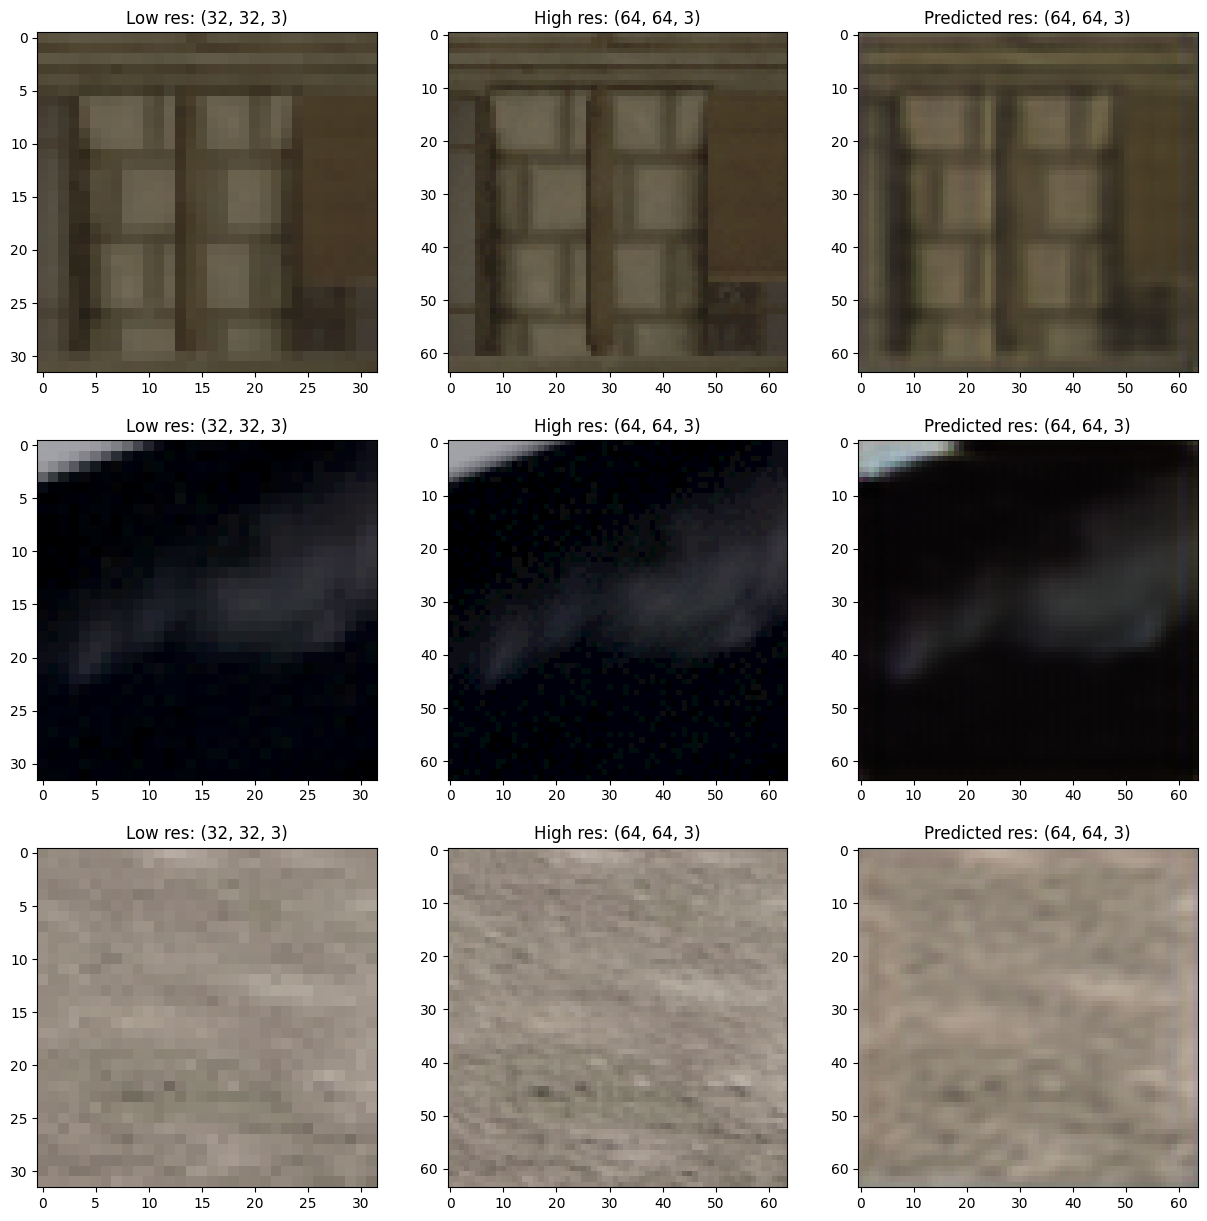

In [13]:
plot_images_from_model(exp, small_dataset, indices=[0, 1, 2])

# Training a model on a subsequent part of the original dataset

In [14]:

# Take the sub part of the dataset from random indices
train_size = int(0.8 * len(train_dataset_patched))
valid_size = len(train_dataset_patched) - train_size

train_sub_dataset, valid_sub_dataset = torch.utils.data.random_split(train_dataset_patched, [train_size, valid_size])

print("Size of train_dataset: ", len(train_sub_dataset))
print("Size of valid_dataset: ", len(valid_sub_dataset))

Size of train_dataset:  3200
Size of valid_dataset:  800


In [15]:
lr = 1e-3
batch_size = 32

torch.cuda.empty_cache()
r = RDN(C=6 , D=20, G=64, G0=64, scaling_factor=2, kernel_size=3, c_dims=train_dataset_patched[0][0].shape[0], upscaling='shuffle', weights=None)
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
path = "results/superresol-rnn200mo"
exp1 = nt.Experiment(r, train_sub_dataset, valid_sub_dataset, adam, stats_manager, device, criterion, batch_size=batch_size,
                     output_dir=path, perform_validation_during_training=True)

# Show number of parameters
print("Number of parameters:", sum(p.numel() for p in r.parameters() if p.requires_grad))

Number of parameters: 16351488


Start/Continue training from epoch 25
Finish training for 25 epochs


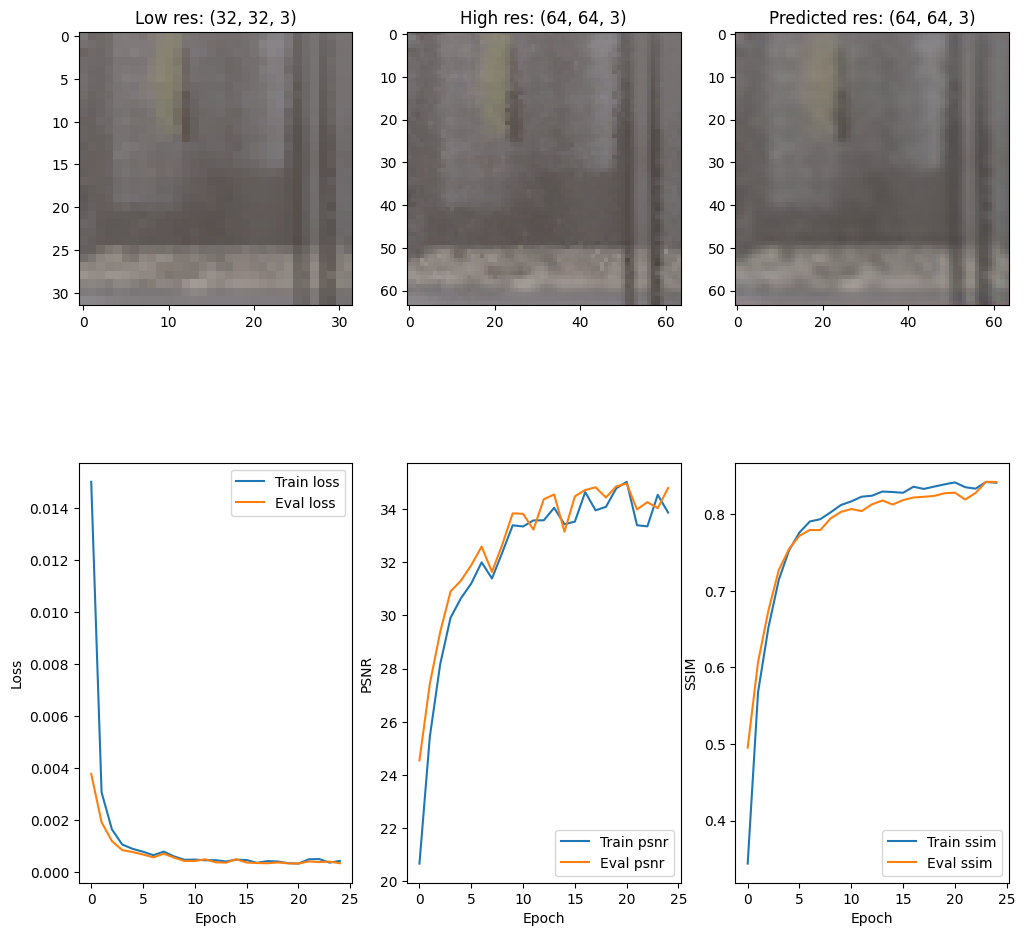

In [16]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
exp1.run(num_epochs=25, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, test_dataset_patched, np.random.randint(len(test_dataset_patched))))
#exp1.run(num_epochs=3, plot=None)

4
Chosen index 149
Chosen index 363
Chosen index 689
Chosen index 692


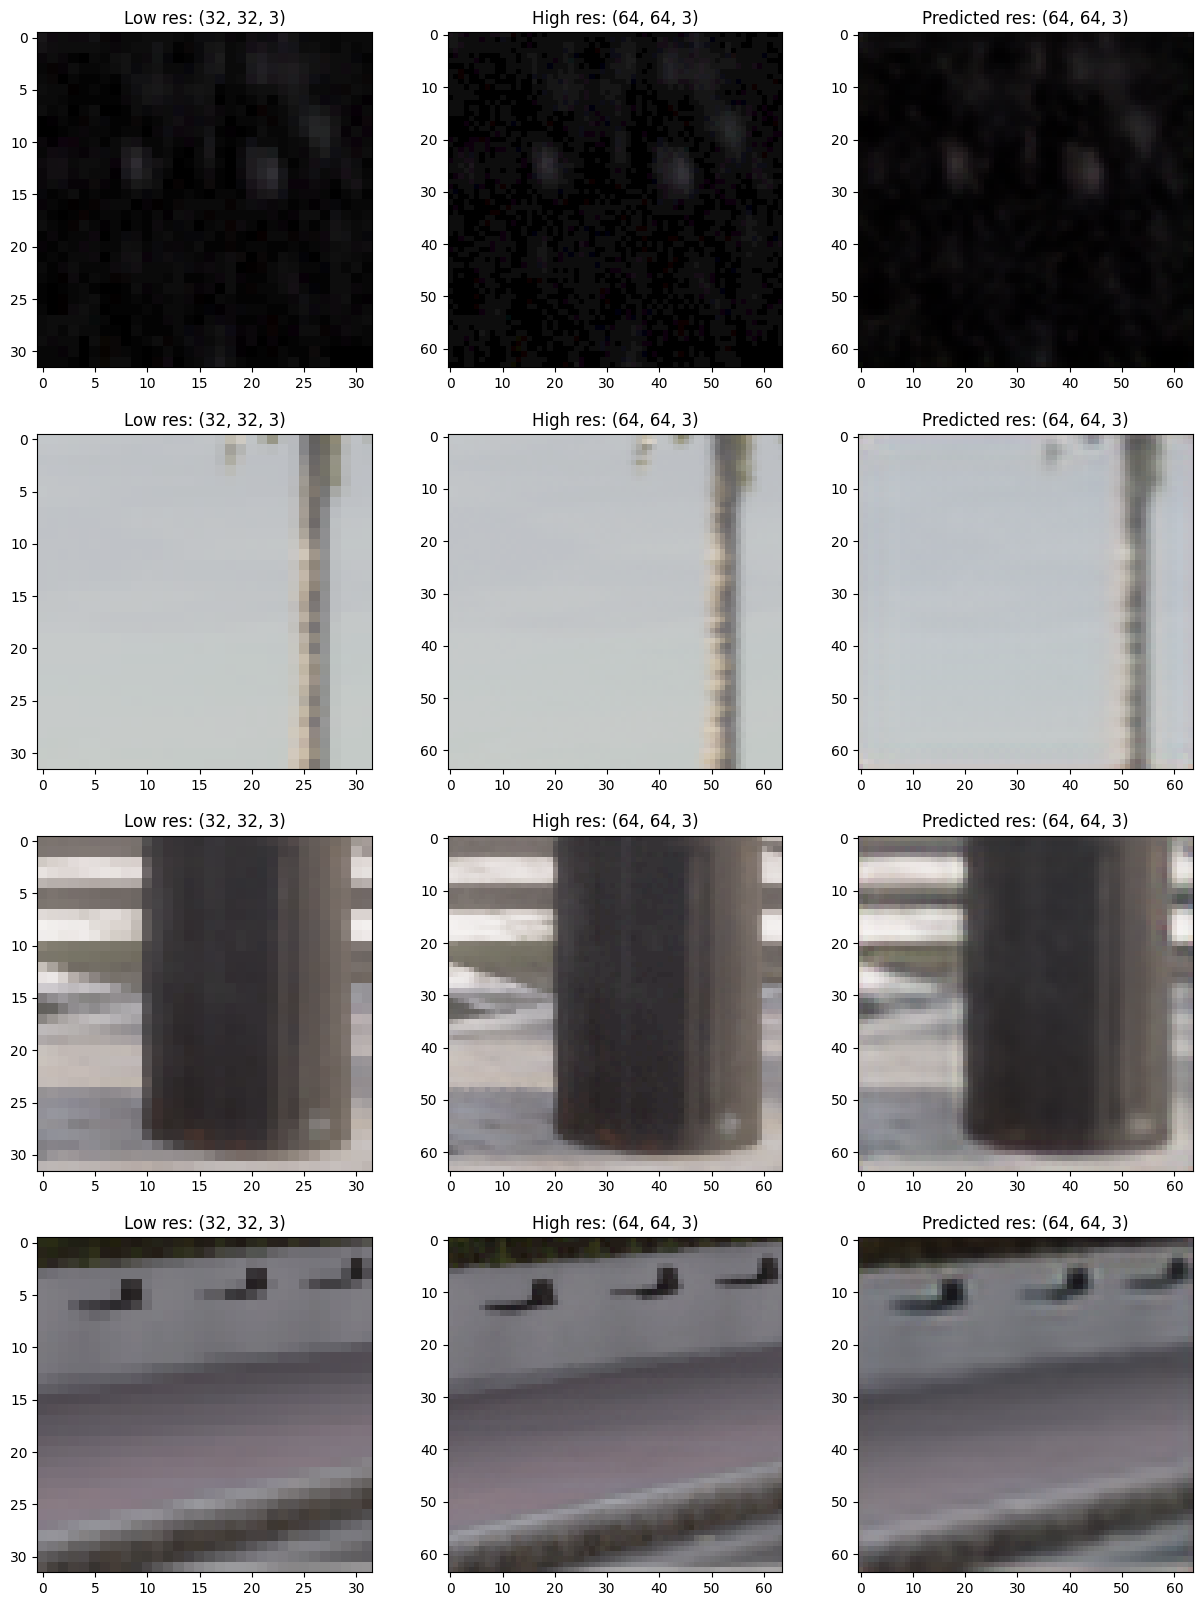

In [17]:
plot_images_from_model(exp1, test_dataset_patched, num_images=4)

4
Chosen index 592
Chosen index 450
Chosen index 776
Chosen index 343


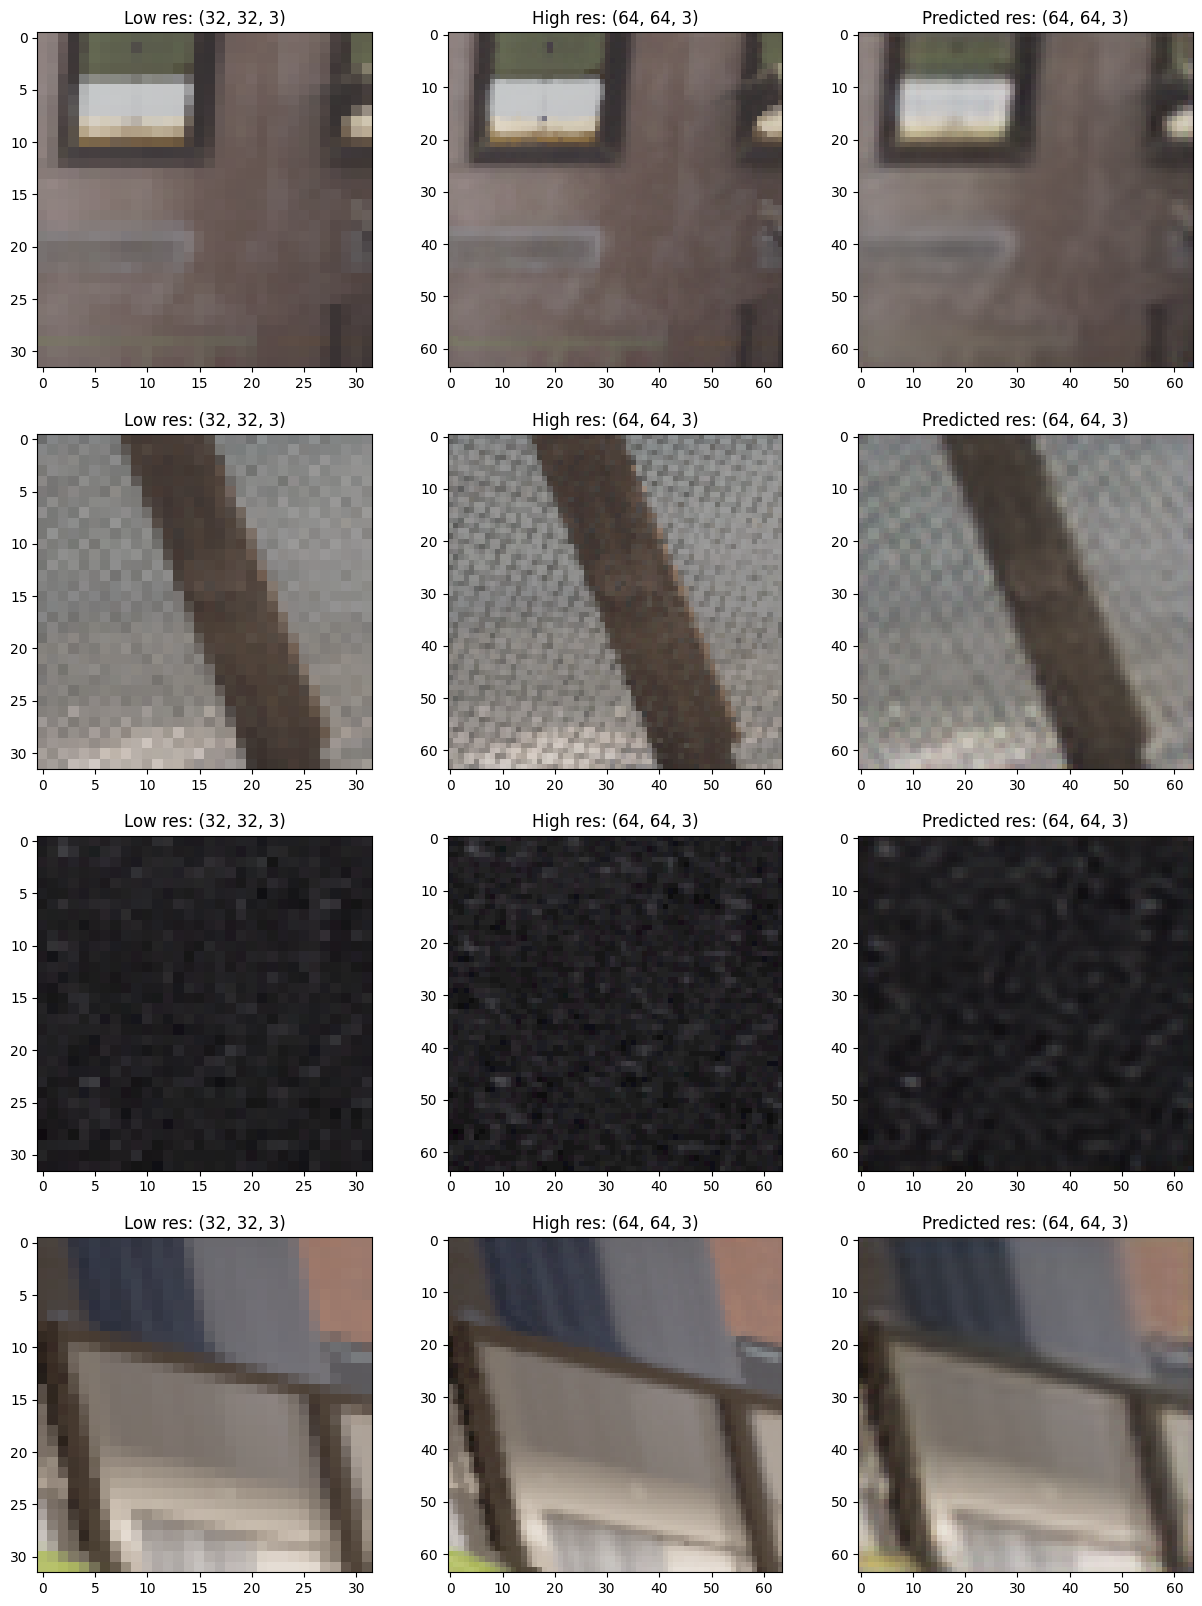

In [18]:
plot_images_from_model(exp1, test_dataset_patched, num_images=4)

# Reconstruct image from patch

In [19]:
from src.PatchImageTool import PatchImageTool

index_patch_train = np.random.randint(len(full_train_dataset))
index_patch_test = np.random.randint(len(full_test_dataset))

print("Choose index train", index_patch_train, "Choose index test", index_patch_test)

start_index_patch_train = full_train_dataset.get_index_start_patch(index_patch_train)
start_index_patch_test = full_test_dataset.get_index_start_patch(index_patch_test)

print ("Start index patch train", start_index_patch_train, "Start index patch test", start_index_patch_test)

index_train = full_train_dataset.get_index_for_image(index_patch_train)
index_test = full_test_dataset.get_index_for_image(index_patch_test)

print ("Index train", index_train, "Index test", index_test)

train_low_res, train_high_res = full_train_dataset.get_full_image(index_train)
test_low_res, test_high_res = full_test_dataset.get_full_image(index_test)

pred_high_res1 = PatchImageTool.predict_image_from_dataset_patches(exp1, (1920, 1080), full_train_dataset, index_patch_train, device)
pred_high_res2 = PatchImageTool.predict_image_from_dataset_patches(exp1, (1920, 1080), full_test_dataset, index_patch_test, device)

Choose index train 399184 Choose index test 89541
Start index patch train 398820 Start index patch test 89250
Index train 782 Index test 175


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.25 GiB. GPU 0 has a total capacty of 7.79 GiB of which 1.11 GiB is free. Process 6761 has 1.67 GiB memory in use. Process 6859 has 572.00 MiB memory in use. Including non-PyTorch memory, this process has 4.43 GiB memory in use. Of the allocated memory 2.99 GiB is allocated by PyTorch, and 1.28 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

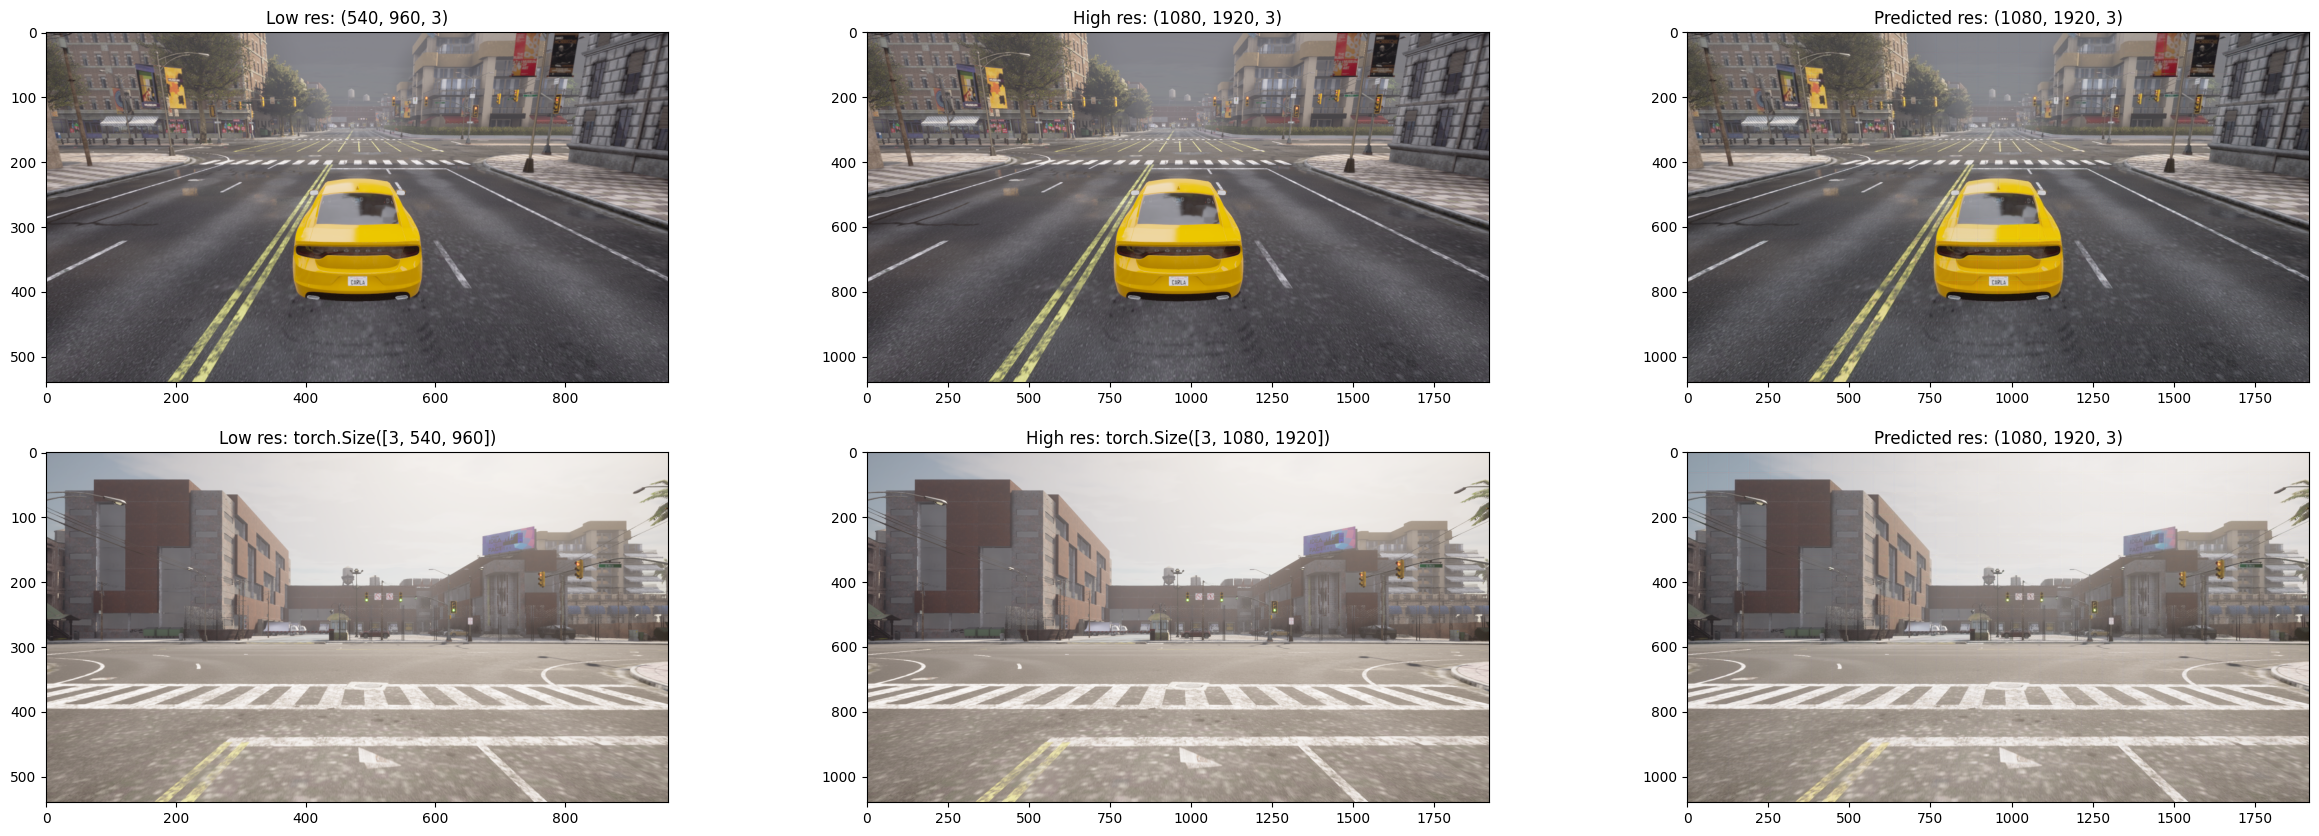

In [ ]:
## Test on one image from the train and test set

fig, axes = plt.subplots(2, 3, figsize=(30, 10))

train_low_res_image = tensor_to_image(train_low_res)
train_high_res_image = tensor_to_image(train_high_res)
pred_high_res1_image = tensor_to_image(pred_high_res1)

axes[0][0].set_title(f'Low res: {train_low_res_image.shape}')
axes[0][1].set_title(f'High res: {train_high_res_image.shape}')
axes[0][2].set_title(f'Predicted res: {pred_high_res1_image.shape}')

axes[0][0].imshow(train_low_res_image)
axes[0][1].imshow(train_high_res_image)
axes[0][2].imshow(pred_high_res1_image)

test_low_res_image = tensor_to_image(test_low_res)
test_high_res_image = tensor_to_image(test_high_res)
pred_high_res2_image = tensor_to_image(pred_high_res2)

axes[1][0].set_title(f'Low res: {test_low_res.shape}')
axes[1][1].set_title(f'High res: {test_high_res.shape}')
axes[1][2].set_title(f'Predicted res: {pred_high_res2_image.shape}')

axes[1][0].imshow(test_low_res_image)
axes[1][1].imshow(test_high_res_image)
axes[1][2].imshow(pred_high_res2_image)

plt.show()

In [ ]:
# Compute the PSNR and SSIM for the predicted image

train_high_res_np = tensor_to_numpy(train_high_res)
test_high_res_np = tensor_to_numpy(test_high_res)

pred_high_res1_np = tensor_to_numpy(pred_high_res1)
pred_high_res2_np = tensor_to_numpy(pred_high_res2)

print("PSNR for train image", metrics.peak_signal_noise_ratio(train_high_res_np, pred_high_res1_np))
print("SSIM for train image", metrics.structural_similarity(train_high_res_np, pred_high_res1_np, win_size=7, 
                                                            data_range=1, multichannel=True, channel_axis=2))

print("PSNR for test image", metrics.peak_signal_noise_ratio(test_high_res_np, pred_high_res2_np))
print("SSIM for test image", metrics.structural_similarity(test_high_res_np, pred_high_res2_np, win_size=7, 
                                                           data_range=1, multichannel=True, channel_axis=2))

PSNR for train image 37.06370169951935
SSIM for train image 0.9538658
PSNR for test image 38.72217175426714
SSIM for test image 0.971314


In [ ]:
def compute_mean_psnr_ssim(model, dataset, subpart_size):
    psnr = 0
    ssim = 0

    # array of unique indices
    indices = np.random.choice(len(dataset), subpart_size, replace=False)

    for i in range(subpart_size):
        index_patch = indices[i]

        index_image = dataset.get_index_for_image(index_patch)
        
        low_res, high_res = dataset.get_full_image(index_image)
        pred_high_res = predict_full_image_by_patch(model, 1920, 1080, dataset, index_patch)

        high_res_np = tensor_to_numpy(high_res)
        pred_high_res_np = tensor_to_numpy(pred_high_res)

        psnr += metrics.peak_signal_noise_ratio(high_res_np, pred_high_res_np)
        ssim += metrics.structural_similarity(high_res_np, pred_high_res_np, win_size=7, data_range=1, multichannel=True, channel_axis=2)

    return psnr / subpart_size, ssim / subpart_size

In [ ]:
subpart_size = 100

# Compute the PSNR and SSIM for the predicted image on a subset of the train set
train_psnr, train_ssim = compute_mean_psnr_ssim(exp1, full_train_dataset, subpart_size)

# Compute the PSNR and SSIM for the predicted image on a subset of the test set
test_psnr, test_ssim = compute_mean_psnr_ssim(exp1, full_test_dataset, subpart_size)


In [ ]:
print("Average PSNR for test images", test_psnr)
print("Average SSIM for test images", test_ssim)

print("Average PSNR for train images", train_psnr)
print("Average SSIM for train images", train_ssim)

Average PSNR for test images 35.035351784151636
Average SSIM for test images 0.9152803295850753
Average PSNR for train images 35.772707906438775
Average SSIM for train images 0.931483148932457
